In [ ]:
# Image Segmentation Using Prebuilt models and Decoder layer
# A U-Net consists of an encoder (downsampler) and decoder (upsampler).
# In-order to learn robust features, and reduce the number of trainable parameters,
# a pretrained model can be used as the encoder.

"""
 In this case you will want to segment the image, i.e., each pixel of the image
  is given a label. Thus, the task of image segmentation is to train a neural network
  to output a pixel-wise mask of the image. This helps in understanding the image
  at a much lower level, i.e., the pixel level. Image segmentation has many applications
  in medical imaging, self-driving cars and satellite imaging to name a few.

  """


In [2]:
# Import public dataset module ready to use with tensorflow. It contains the last versions of the datasets.
!pip install tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.5 MB/s eta 0:00:00


In [1]:
# Restart the kernel before proceeding further (On the Notebook menu, select Kernel > Restart Kernel > Restart).

In [2]:
# Install package containing prebuilt image models
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-vzutmc63
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-vzutmc63
  Resolved https://github.com/tensorflow/examples.git to commit 0bbf4fe43fbf41b7174b9ce4a64d69bd33aadd21
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1689703202.67065300351684276117070052891639684042406419745-py3-none-any.whl size=301556 sha256=88fe4193cbfd9d3df59f16af41da9bf896c8651074b1226be502960d547bf4c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fd6pwkb/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
# Import tensorflow
import tensorflow as tf
print(tf.__version__)

2.12.0


In [4]:
# Import pix2pix model for prebuilt encoder layer which will be used in segmentation model
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
# Download and read the oxford_iiit_pet:3.*.* dataset into a tf.data.Dataset.
"""
The dataset that will be used for this tutorial is the Oxford-IIIT Pet Dataset,
created by Parkhi et al. The dataset consists of images, their corresponding labels,
and pixel-wise masks. The masks are basically labels for each pixel.
Each pixel is given one of three categories :

Class 1 : Pixel belonging to the pet.
Class 2 : Pixel bordering the pet.
Class 3 : None of the above/ Surrounding pixel.
"""

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteSYLKJV/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteSYLKJV/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
# In addition, image is normalized to [0,1]. Finally, as mentioned above the pixels
# in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience,
# let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
# Function to load images and apply image augmentation on training dataset

@tf.function
def load_image_train(datapoint):
  # Preprocessing layer
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  # Image Augmentation layers : random flip
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    input_image = tf.image.flip_up_down(input_image)
    input_mask = tf.image.flip_up_down(input_mask)

  # Image augmentation layer : random crop

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
# No augmentation is not needed for test dataset

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
# Setting Hyperparameters
TRAIN_LEN = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LEN // BATCH_SIZE

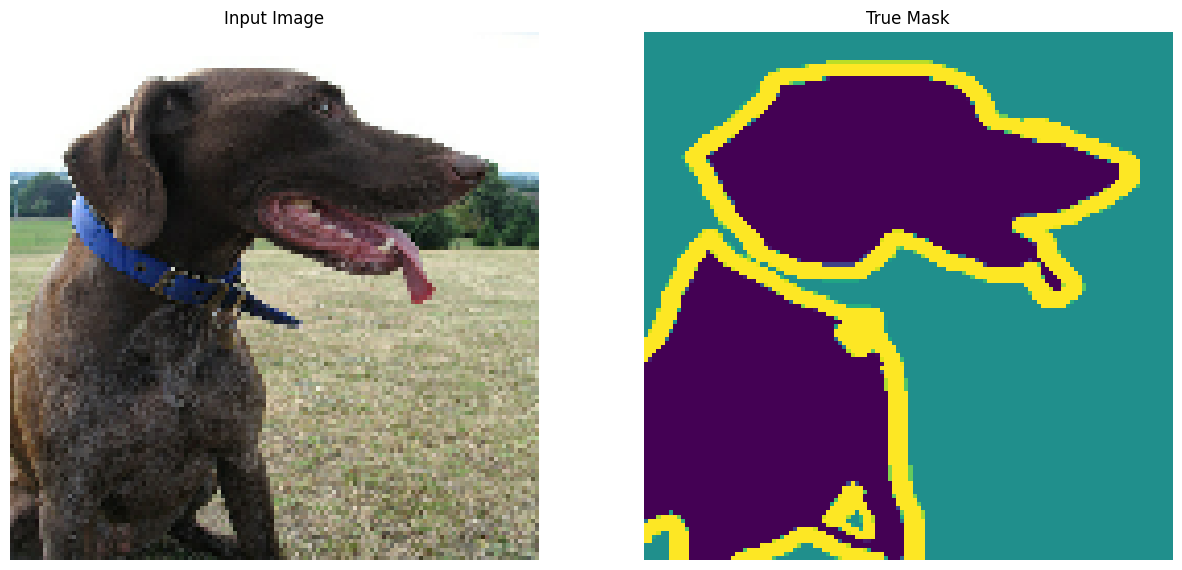

In [35]:
# Visualize the datset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
for image, mask in train.take(109):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [11]:
# creating Input pipeline for distributed training

train_ds = (
    dataset['train']
    .map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    )

test_ds = (
    dataset['test']
    .map(load_image_test)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

In [ ]:
# Model : Here we will be training U-Net model for Image segmentation
# It is pixel-level classification and also multi-class classification where
# each pixel is being classified into three classes.
"""
The encoder for this task will be a pretrained MobileNetV2 model,
whose intermediate outputs will be used, and the decoder will be the upsample block
"""

In [13]:
# Setting number of output channels : number of classes = 3
OUTPUT_CHANNELS = 3

In [14]:
# The encoder will be a pretrained MobileNetV2 model which is prepared and ready to
# use in tf.keras.applications. The encoder consists of specific outputs from intermediate
# layers in the model.

# Note that the encoder will not be trained during the training process.

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)


9406464/9406464 [==============================] - 0s 0us/step


In [15]:
config = base_model.get_config()
for layer in config['layers']:
  new_name = layer['name']
  print(new_name)

input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [ ]:
"""
MobileNetV2 is a neural network architecture that follows a building block design.
 Each block contains a series of convolutional and activation layers.
 The architecture consists of multiple blocks stacked on top of each other,
 with increasing depth as you go deeper into the network

 e.g:
 Input
|
|----- Block 1 (Initial Block) -----
|        |----- Convolution (1x1)
|        |----- Batch Normalization
|        |----- ReLU Activation
|        |----- Depthwise Convolution (3x3, stride 1)
|        |----- Batch Normalization
|        |----- ReLU Activation
|        |----- Convolution (1x1)
|        |----- Batch Normalization
|        |----- Skip Connection (if needed)
|
|----- Block 2 -----
|        |----- Depthwise Convolution (3x3, stride 2)
|        |----- Batch Normalization
|        |----- ReLU Activation
|        |----- Convolution (1x1)
|        |----- Batch Normalization
|        |----- Skip Connection (if needed)
|
|----- ... (Additional Blocks) -----
|
|----- Block N (Final Block) -----
|        |----- Depthwise Convolution (3x3, stride 2)
|        |----- Batch Normalization
|        |----- ReLU Activation
|        |----- Convolution (1x1)
|        |----- Batch Normalization
|        |----- Global Average Pooling
|        |----- Fully Connected (Dense) Layer (for classification or other tasks)
|
Output
"""

# These are part of expansion (encoding) phase.
# The expansion phase aims to increase the number of channels in the feature maps
# to capture more diverse features.

"""
layer mapping :
block_1_expand -> Convolution (1x1)

block_1_expand_BN -> Bantch Normalization

block_1_expand_relu -> ReLU

block_1_pad -> Padding layer

block_1_depthwise -> Depthwise Convolution

block_1_depthwise_BN -> Batch Normalisation After depthwise Conv

block_1_depthwise_relu -> ReLU

block_1_project -> Fully Connected Layer

block_1_project_BN  -> Batch Normalisation

"""


# Note: Layers at different depths of the network capture features at different
# levels of abstraction and spatial resolutions. Layers closer to the input have higher
# spatial resolutions but capture simpler features, while deeper layers have lower
# spatial resolutions but capture more complex features.

# The convolution layers learn such complex features by building on top of each other.
# The first layers detect edges, the next layers combine them to detect shapes.

In [33]:

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model also called Encoder Layers.
encoding_layer_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

encoding_layer_stack.trainable = False

In [34]:
# Decoding layer

decoding_layer_stack = [
    pix2pix.upsample(512, 3),   # 4x4 -> 8x8
    pix2pix.upsample(256, 3),   # 8x8 -> 16x16
    pix2pix.upsample(128, 3),   # 16x16 -> 32x32
    pix2pix.upsample(64, 3),    # 32x32 -> 64x64
]

In [31]:
# U-Net Segmentation model

def unet_segmentation_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Encoder Layer: Downsampling through the model
  encoding_skips = encoding_layer_stack(inputs)
  x = encoding_skips[-1]
  encoding_skips = reversed(encoding_skips[:-1])

  # Decoder: Upsampling and establishing the skip connections
  for up, encoding_skip in zip(decoding_layer_stack, encoding_skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, encoding_skip])

  # Output Layer: This is the last layer of the model
  last_decoding_layer = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')                # 64x64 -> 128x128

  output = last_decoding_layer(x)

  return tf.keras.Model(inputs=inputs, outputs=output)

In [36]:
# Compile and display model architecture
model = unet_segmentation_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           [(None, 64, 64, 96)  1841984     ['input_6[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

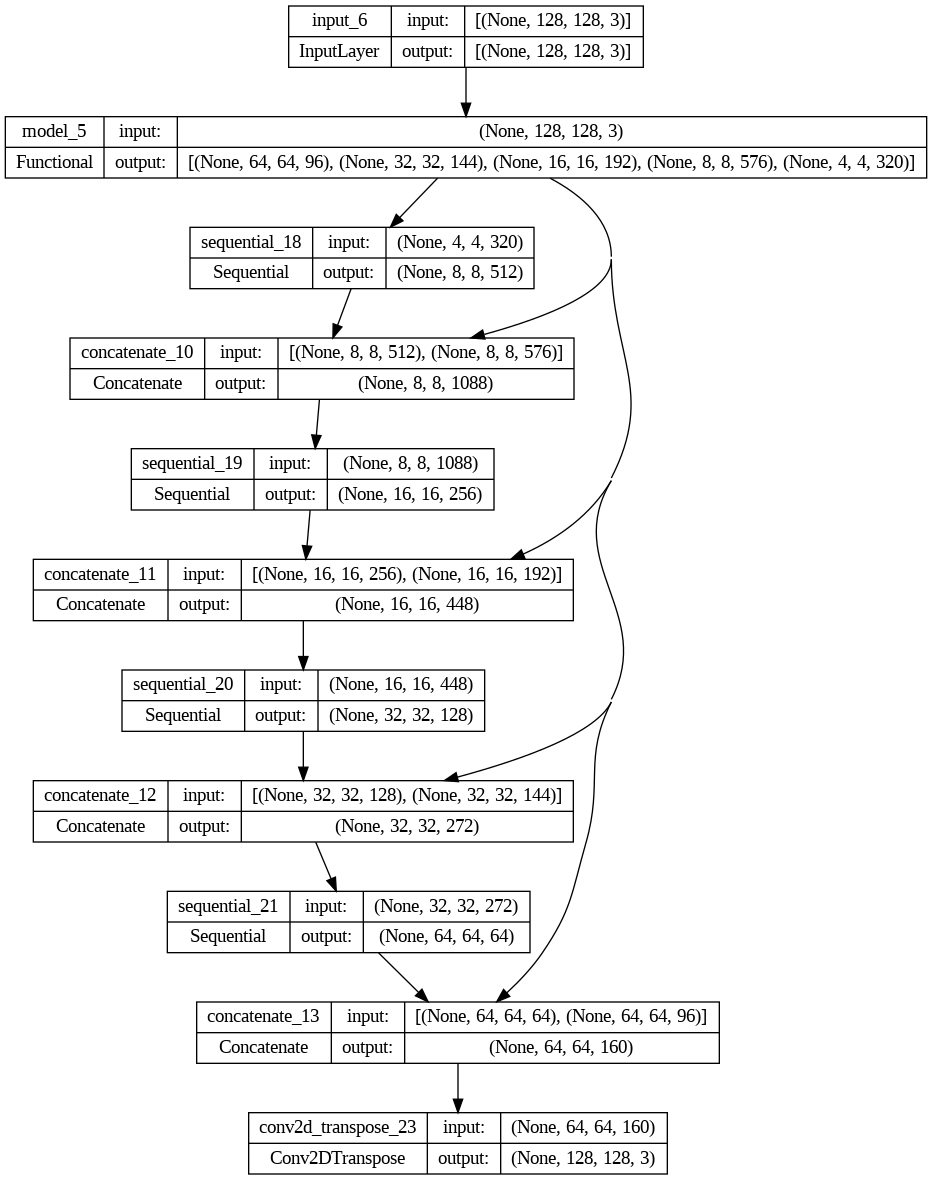

In [37]:
# Converts a Keras model to dot format and save to a file.
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
# Creating prediction display function
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=90):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [39]:
#
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 36ms/step


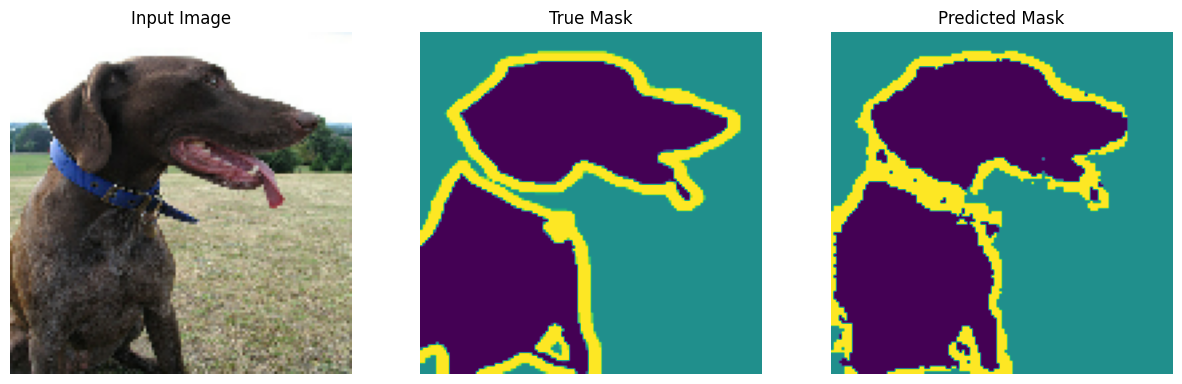


Sample Prediction after epoch 15

57/57 [==============================] - 10s 182ms/step - loss: 0.1729 - accuracy: 0.9230 - val_loss: 0.3032 - val_accuracy: 0.8885


In [40]:
# Setting parameters and start model training
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()])

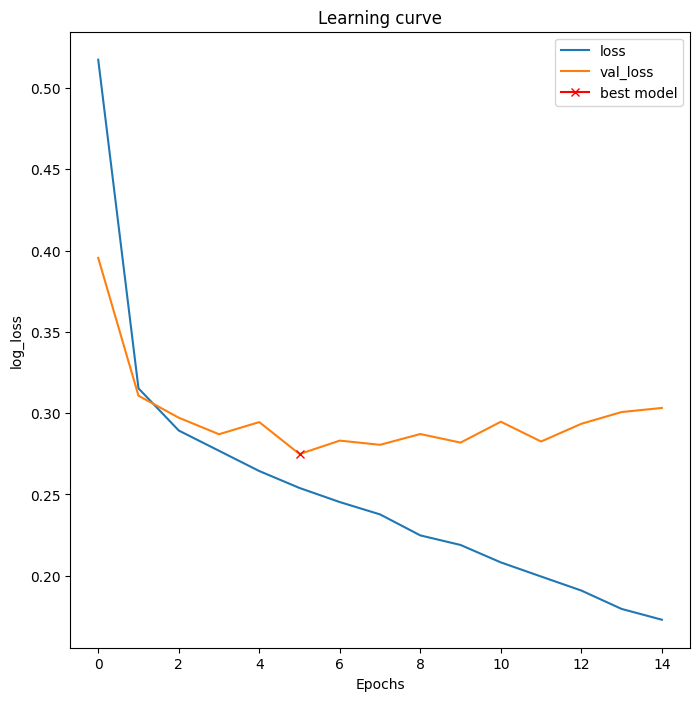

In [41]:
#
import numpy as np
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plotting Loss per epochs for model learning
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

2/2 [==============================] - 0s 42ms/step


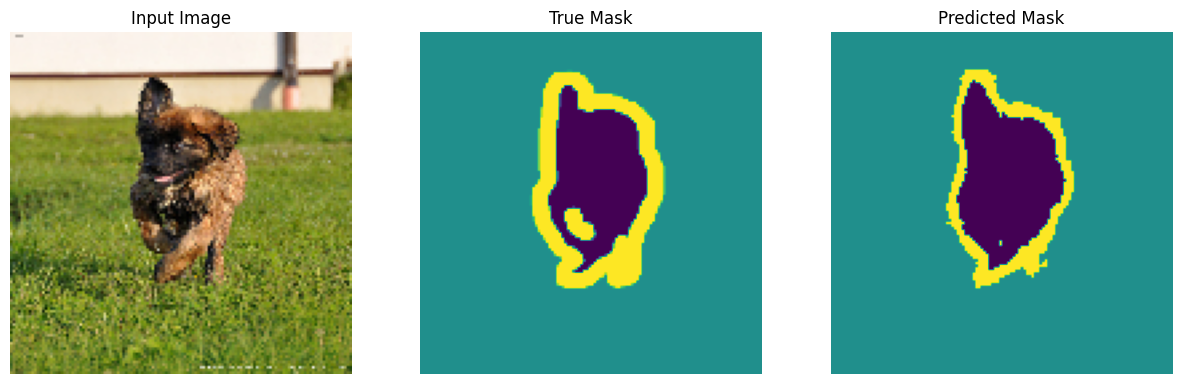

2/2 [==============================] - 0s 42ms/step


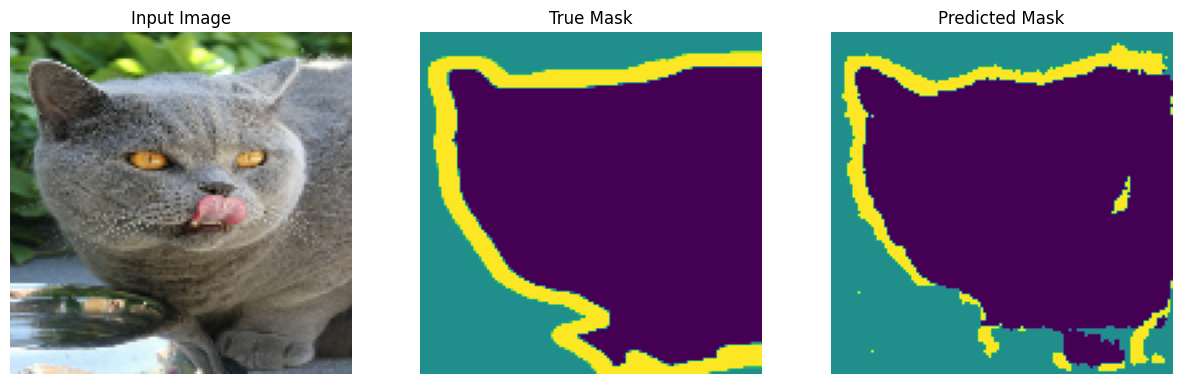

2/2 [==============================] - 0s 41ms/step


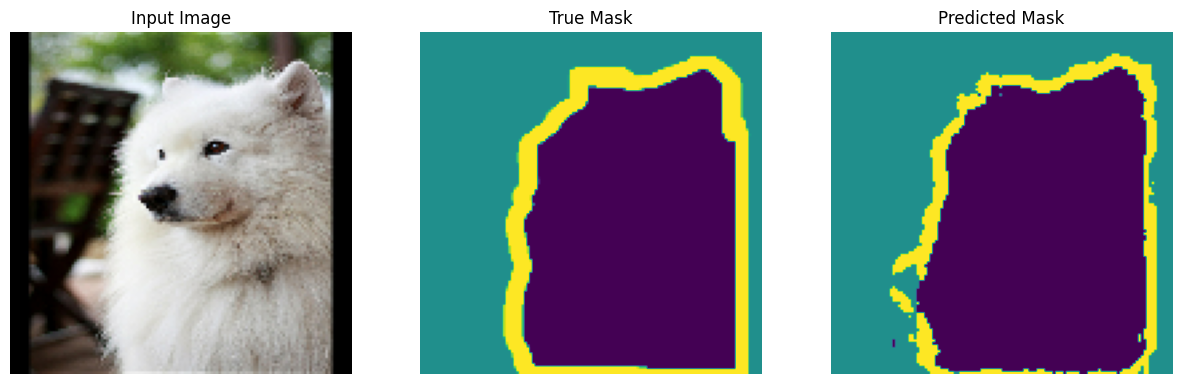

In [42]:
# Make predictions from test dataset
show_predictions(test_ds, 3)